In [ ]:
import os

import psycopg
import pandas as pd
import mlflow
from catboost import CatBoostClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from autofeat import AutoFeatClassifier

TABLE_NAME = "users_churn"
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "test_connection_experiment_vadim_shakula"
RUN_NAME = "feature_selection"
REGISTRY_MODEL_NAME = "churn_model_vadimshakula"

ModuleNotFoundError: No module named 'MlflowClient'

In [2]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        sql = """
            select customer_id,
                   begin_date,
                   end_date,
                   type,
                   paperless_billing,
                   payment_method,
                   monthly_charges,
                   total_charges,
                   internet_service,
                   online_security,
                   online_backup,
                   device_protection,
                   tech_support,
                   streaming_tv,
                   streaming_movies,
                   gender,
                   senior_citizen,
                   partner,
                   dependents,
                   multiple_lines,
                   target
            from users_churn
        """
        cur.execute(sql)
        data = cur.fetchall()                       
        columns = [desc.name for desc in cur.description] 

df = pd.DataFrame(data, columns=columns)

In [12]:
# ================== Полный рабочий блок для SFS/SBS с кэшем ==================
# Импорты и базовые настройки
import os
import pickle
from pathlib import Path
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# --- управляем кэшированием и путями ---
FORCE_REFIT = bool(int(os.getenv("FORCE_REFIT", "0")))  # 0/1 из окружения; по умолчанию False
CACHE_DIR = Path(os.getenv("SELECTOR_CACHE_DIR", "./selector_cache"))
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# -------- вспомогалки ----------
def _hash_config(d: dict) -> str:
    import hashlib
    return hashlib.md5(repr(sorted(d.items())).encode("utf-8")).hexdigest()[:12]

def _selector_signature(sel) -> dict:
    sig = {}
    for attr in ["k_features", "forward", "floating", "scoring", "cv", "n_jobs"]:
        if hasattr(sel, attr):
            sig[attr] = getattr(sel, attr)
    est = getattr(sel, "estimator", None)
    if est is not None:
        sig["estimator_cls"] = est.__class__.__name__
        try:
            sig["estimator_params"] = est.get_params()
        except Exception:
            sig["estimator_params"] = str(est)
    return sig

def _data_signature(X, y) -> dict:
    cols = getattr(X, "columns", None)
    if cols is not None:
        cols = tuple(map(str, cols))
    xshape = getattr(X, "shape", None)
    yshape = getattr(y, "shape", None)
    return {"X_cols": cols, "X_shape": xshape, "y_shape": yshape}

def cached_fit_selector(selector, X, y, name: str, force_refit: bool=False):
    cfg = {"name": name}
    cfg.update(_selector_signature(selector))
    cfg.update(_data_signature(X, y))
    key = _hash_config(cfg)
    path = CACHE_DIR / f"{name}_{key}.pkl"
    if path.exists() and not force_refit:
        with open(path, "rb") as f:
            return pickle.load(f)
    fitted = selector.fit(X, y)
    with open(path, "wb") as f:
        pickle.dump(fitted, f)
    return fitted

# -------- подхватываем твои данные из предыдущей ячейки ----------
# Ожидается, что переменные X_train_features, X_test_features, y_train уже существуют.
X_tr = X_train_features
X_te = X_test_features
# делаем y одномерным (на случай, если это DataFrame со столбцом 'target')
y_tr = np.ravel(y_train.values if hasattr(y_train, "values") else y_train)

# --- имена признаков для вывода (если это не DataFrame — создадим f0, f1, ...) ---
if hasattr(X_tr, "columns"):
    feature_names = list(map(str, X_tr.columns))
else:
    feature_names = [f"f{i}" for i in range(X_tr.shape[1])]

# (опционально) ускоряем вычисления float32
try:
    if hasattr(X_tr, "astype"):
        X_tr = X_tr.astype(np.float32, copy=False)
        if X_te is not None and hasattr(X_te, "astype"):
            X_te = X_te.astype(np.float32, copy=False)
except Exception:
    pass

# --- безопасно определим k_features (не больше числа признаков и >=1) ---
n_features = X_tr.shape[1]
k_best = max(1, min(10, n_features))

# лёгкий RF для селекции (быстрее, чем глубокий лес)
selector_estimator = RandomForestClassifier(
    n_estimators=120,
    max_depth=8,
    min_samples_leaf=5,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42,
)

# более дешёвый CV
cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# --- SFS (forward) ---
sfs = SFS(
    selector_estimator,
    k_features=k_best,
    forward=True,
    floating=False,      # floating существенно дороже; отключаем
    scoring="roc_auc",
    cv=cv3,
    n_jobs=-1,
    verbose=0,
)
sfs = cached_fit_selector(sfs, X_tr, y_tr, name="sfs", force_refit=FORCE_REFIT)

# --- SBS (backward) ---
sbs = SFS(
    selector_estimator,
    k_features=k_best,
    forward=False,
    floating=False,
    scoring="roc_auc",
    cv=cv3,
    n_jobs=-1,
    verbose=0,
)
sbs = cached_fit_selector(sbs, X_tr, y_tr, name="sbs", force_refit=FORCE_REFIT)

# --- извлекаем выбранные индексы/имена признаков
def _chosen_names(selector, all_names):
    idx = getattr(selector, "k_feature_idx_", None)
    if idx is None:
        # запасной вариант — попробуем k_feature_names_; если нет — вернём пустой кортеж
        names = getattr(selector, "k_feature_names_", ())
        return tuple(map(str, names)) if names else ()
    return tuple(all_names[i] for i in idx)

top_sfs = _chosen_names(sfs, feature_names)
top_sbs = _chosen_names(sbs, feature_names)

# --- трансформации обучающей/тестовой выборок
X_train_sfs = sfs.transform(X_tr)
X_train_sbs = sbs.transform(X_tr)
X_test_sfs  = sfs.transform(X_te) if X_te is not None else None
X_test_sbs  = sbs.transform(X_te) if X_te is not None else None

# --- вывод результатов
print(f"Число исходных признаков: {n_features}")
print(f"Выбираем k_features = {k_best}")

print("\nSequential Forward Selection (SFS)")
print("CV AUC:", getattr(sfs, "k_score_", None))
print("Top features:", top_sfs)

print("\nSequential Backward Selection (SBS)")
print("CV AUC:", getattr(sbs, "k_score_", None))
print("Top features:", top_sbs)
# ============================================================================== 


Число исходных признаков: 40
Выбираем k_features = 10

Sequential Forward Selection (SFS)
CV AUC: 0.8132787837411849
Top features: ('monthly_charges', 'total_charges', 'cat_paperless_billing_Yes', 'cat_payment_method_Bank transfer (automatic)', 'cat_internet_service_Fiber optic', 'cat_streaming_tv_Yes', 'cat_streaming_movies_No', 'cat_senior_citizen_0', 'cat_dependents_No', 'cat_multiple_lines_No')

Sequential Backward Selection (SBS)
CV AUC: 0.816496964536931
Top features: ('total_charges', 'cat_paperless_billing_Yes', 'cat_payment_method_Bank transfer (automatic)', 'cat_internet_service_Fiber optic', 'cat_online_security_Yes', 'cat_tech_support_Yes', 'cat_streaming_tv_Yes', 'cat_streaming_movies_None', 'cat_gender_Female', 'cat_multiple_lines_Yes')


In [13]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T 

In [18]:
import os

# создаём папку, если её нет
os.makedirs(FS_ASSETS, exist_ok=True)

# пути к файлам
sfs_path = os.path.join(FS_ASSETS, "sfs.csv")
sbs_path = os.path.join(FS_ASSETS, "sbs.csv")

# удаляем старые версии, если есть
for path in [sfs_path, sbs_path]:
    if os.path.exists(path):
        os.remove(path)

# сохраняем новые
sfs_df.to_csv(sfs_path, index=False)
sbs_df.to_csv(sbs_path, index=False)


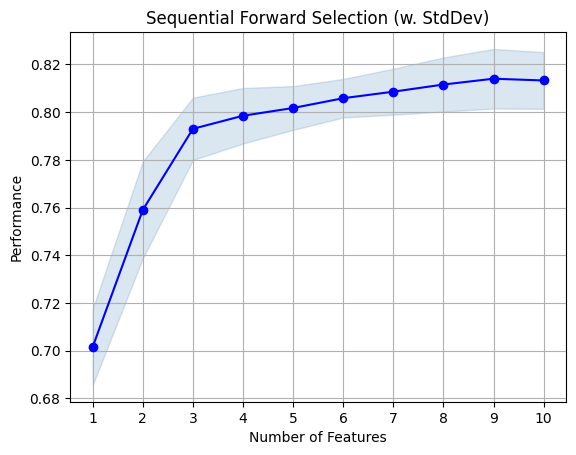

<Figure size 640x480 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

os.makedirs(FS_ASSETS, exist_ok=True)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

path = "fs_assets/sfs.png"
if os.path.exists(path):
    os.remove(path)

plt.savefig("fs_assets/sfs.png") 

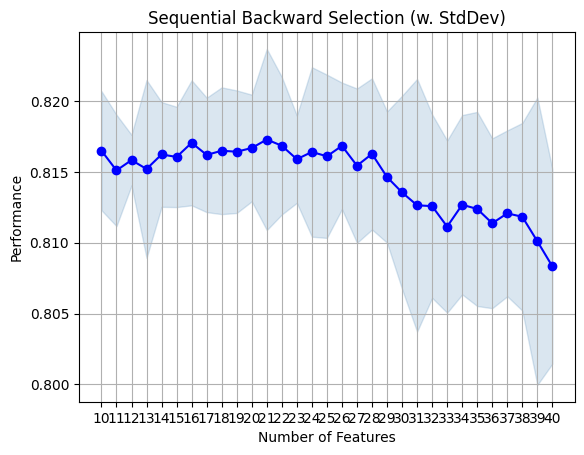

<Figure size 640x480 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

os.makedirs(FS_ASSETS, exist_ok=True)
fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

path = "fs_assets/sbs.png"
if os.path.exists(path):
    os.remove(path)

plt.savefig("fs_assets/sbs.png") 

In [33]:
interc_features = list(set(top_sbs) & set(top_sfs))
union_features = list(set(top_sbs) | set(top_sfs))

In [34]:
print(interc_features)
print(union_features)

['cat_internet_service_Fiber optic', 'cat_payment_method_Bank transfer (automatic)', 'cat_paperless_billing_Yes', 'cat_streaming_tv_Yes', 'total_charges']
['cat_streaming_movies_No', 'cat_payment_method_Bank transfer (automatic)', 'cat_streaming_tv_Yes', 'cat_streaming_movies_None', 'total_charges', 'cat_multiple_lines_Yes', 'cat_senior_citizen_0', 'cat_multiple_lines_No', 'cat_internet_service_Fiber optic', 'cat_paperless_billing_Yes', 'cat_dependents_No', 'cat_tech_support_Yes', 'cat_gender_Female', 'monthly_charges', 'cat_online_security_Yes']


In [37]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv('AWS_ACCESS_KEY_ID')
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv('AWS_SECRET_ACCESS_KEY')

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=f"{RUN_NAME}_intersection_and_union", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
   
    mlflow.log_artifacts(FS_ASSETS) 

2025-09-05 16:00:30,925 INFO: Found credentials in environment variables.


In [41]:
print(run_id)
print(EXPERIMENT_NAME)
print(RUN_NAME)

65a14a7ac09b4e20a3e6720062e24331
test_connection_experiment_vadim_shakula
feature_selection


In [42]:
# --- Registered Model name ---
registered_model_name = "feature_selection"

In [44]:
# --- Формируем множества признаков ---
print("Intersection:", interc_features)
print("Union:", union_features)

Intersection: ['cat_internet_service_Fiber optic', 'cat_payment_method_Bank transfer (automatic)', 'cat_paperless_billing_Yes', 'cat_streaming_tv_Yes', 'total_charges']
Union: ['cat_streaming_movies_No', 'cat_payment_method_Bank transfer (automatic)', 'cat_streaming_tv_Yes', 'cat_streaming_movies_None', 'total_charges', 'cat_multiple_lines_Yes', 'cat_senior_citizen_0', 'cat_multiple_lines_No', 'cat_internet_service_Fiber optic', 'cat_paperless_billing_Yes', 'cat_dependents_No', 'cat_tech_support_Yes', 'cat_gender_Female', 'monthly_charges', 'cat_online_security_Yes']


In [45]:
# --- Базовый алгоритм ---
estimator = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

In [49]:
def train_log_register(X_train, X_test, y_train, y_test, features, experiment_name, run_name):
    # Выбираем признаки
    Xtr = X_train[features]
    Xte = X_test[features]

    mlflow.set_experiment(experiment_name)
    experiment = mlflow.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id
    
    with mlflow.start_run(run_name=run_name, experiment_id=experiment_id) as run:
        run_id = run.info.run_id

        # Обучение
        model = estimator.fit(Xtr, y_train)

        # Метрики
        y_pred = model.predict(Xte)
        y_proba = model.predict_proba(Xte)[:, 1]
        metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_proba),
        }
        mlflow.log_metrics(metrics)

        # Регистрируем модель
        model_info = mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model",
            registered_model_name=registered_model_name,
            input_example=Xtr.iloc[:5],
            metadata={"n_features": len(features), "feature_set": run_name}
        )

    return run_id, run_name, model_info.model_version

In [57]:
import numpy as np
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    r2_score, mean_squared_error, mean_absolute_error
)

# ---- Определяем тип задачи по y_train ----
def _guess_problem_type(y):
    t = type_of_target(np.ravel(y))
    return "classification" if t in ("binary", "multiclass") else "regression"

_problem = _guess_problem_type(y_train)

# ---- Базовые пайплайны с импутацией ----
if _problem == "classification":
    base_model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
    ])
else:
    base_model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
    ])

def _compute_metrics(y_true, y_pred, proba=None):
    if _problem == "classification":
        m = {
            "accuracy": float(accuracy_score(y_true, y_pred)),
            "f1": float(f1_score(y_true, y_pred, average="weighted")),
        }
        if proba is not None:
            # если (n,2) — берём proba положительного класса
            pos = proba[:, 1] if (proba.ndim == 2 and proba.shape[1] == 2) else proba
            try:
                m["roc_auc"] = float(roc_auc_score(y_true, pos))
            except Exception:
                pass
        return m
    else:
        return {
            "rmse": float(mean_squared_error(y_true, y_pred, squared=False)),
            "mae": float(mean_absolute_error(y_true, y_pred)),
            "r2":  float(r2_score(y_true, y_pred)),
        }

def train_log_register(
    Xtr, Xte, ytr, yte, cols, experiment_name, run_name,
    registered_model_name="feature_selection"
):
    # 1) Страхуемся: берём только реально существующие колонки
    cols_exist = [c for c in cols if c in Xtr.columns]
    if not cols_exist:
        raise ValueError("Список признаков пуст после пересечения с колонками трейна.")

    Xtr_s, Xte_s = Xtr[cols_exist], Xte[cols_exist]

    # 2) Правильная форма цели
    ytr_vec = np.ravel(ytr)
    yte_vec = np.ravel(yte)

    # 3) Эксперимент
    mlflow.set_experiment(experiment_name)
    exp = mlflow.get_experiment_by_name(experiment_name)
    experiment_id = exp.experiment_id

    with mlflow.start_run(run_name=run_name, experiment_id=experiment_id) as run:
        run_id = run.info.run_id

        mlflow.log_param("n_features", len(cols_exist))
        mlflow.log_param("features", ",".join(cols_exist))
        mlflow.log_param("problem_type", _problem)

        # 4) Обучение (включая импутацию)
        model = base_model.fit(Xtr_s, ytr_vec)

        # 5) Предсказания и метрики
        y_pred = model.predict(Xte_s)
        proba = None
        if _problem == "classification" and hasattr(model.named_steps["model"], "predict_proba"):
            proba = model.predict_proba(Xte_s)

        metrics = _compute_metrics(yte_vec, y_pred, proba)
        mlflow.log_metrics(metrics)

        # 6) Лог и регистрация
        model_info = mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model",
            registered_model_name=registered_model_name,
            input_example=Xtr_s.iloc[:5],
            metadata={"feature_set": run_name, "n_features": len(cols_exist)}
        )

        # --- robust way to get model version ---
        client = MlflowClient()
        # пробуем быстрый вариант для новых MLflow
        version = getattr(model_info, "registered_model_version", None)
        if version is None:
            # ищем среди версий по имени и текущему run_id
            versions = client.search_model_versions(f"name = '{registered_model_name}'")
            run_id_cur = run.info.run_id
            match = [v for v in versions if v.run_id == run_id_cur]
            if not match:
                # запасной вариант: берём последнюю версию по имени
                # (подходит, если параллельных логов нет)
                match = sorted(versions, key=lambda v: int(v.version))[-1:]
            version = match[0].version

    return run.info.run_id, run_name, str(version)


In [60]:
from mlflow.tracking import MlflowClient

In [64]:
# --- Intersection run ---
run_name_interc = "feature_selection_intersection"
run_id_interc, run_name_interc, model_version_id_interc = train_log_register(
    X_train_features, X_test_features, y_train, y_test,
    interc_features,
    experiment_name="feature_selection_intersection",
    run_name=run_name_interc,
    registered_model_name="feature_selection"
)
model_registered_name_interc = "feature_selection"  

/home/mle-user/.local/lib/python3.10/site-packages/mlflow/models/signature.py:344: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  output_schema = _infer_schema(prediction)
Registered model 'feature_selection' already exists. Creating a new version of this model...
2025/09/05 16:38:49 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to 

In [66]:
# --- Union run ---
run_name_union = "feature_selection_union"
run_id_union, run_name_union, model_version_id_union = train_log_register(
    X_train_features, X_test_features, y_train, y_test,
    union_features,
    experiment_name="feature_selection_union",
    run_name=run_name_union,
    registered_model_name="feature_selection")

/home/mle-user/.local/lib/python3.10/site-packages/mlflow/models/signature.py:344: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  output_schema = _infer_schema(prediction)
Registered model 'feature_selection' already exists. Creating a new version of this model...
2025/09/05 16:39:07 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to 

In [67]:
print("registered_model_name           :", registered_model_name)
print("INTERSECTION → run_name         :", run_name_interc)
print("INTERSECTION → run_id           :", run_id_interc)
print("INTERSECTION → model_version_id :", model_version_id_interc)
print("INTERSECTION → model_reg_name   :", model_registered_name_interc)
print("-" * 60)
print("UNION        → run_name         :", run_name_union)
print("UNION        → run_id           :", run_id_union)
print("UNION        → model_version_id :", model_version_id_union)

registered_model_name           : feature_selection
INTERSECTION → run_name         : feature_selection_intersection
INTERSECTION → run_id           : c23965ff779e40b980753e8a2060c641
INTERSECTION → model_version_id : 6
INTERSECTION → model_reg_name   : feature_selection
------------------------------------------------------------
UNION        → run_name         : feature_selection_union
UNION        → run_id           : ebeed4f7f9b348c08c23d9ad4f3ee53d
UNION        → model_version_id : 7
